In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pymongo
import json
import requests
from bs4 import BeautifulSoup

In [11]:
MONGO_CLIENT = pymongo.MongoClient("mongodb://localhost:27017/")
SDA_DB = MONGO_CLIENT["steam_dota_api"]
MLRS_COL = SDA_DB["multi_real_time_stats"]

In [119]:
# heros_by_names = {}
# heroid_winrate = {}
# headers = {
#     'User-Agent': 'Mozilla/5.0 (X11; Linux i686) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.135 Safari/537.36'}
# page_link = 'https://www.dotabuff.com/heroes/winning'

# f = open('heroes.json')
# data = json.load(f)

# for hero in data:
#     heros_by_names[hero['localized_name']] = hero['id']

# page_response = requests.get(page_link, timeout=5, headers=headers)
# soup = BeautifulSoup(page_response.content, "html.parser")
# trs = soup.find_all('tr')
# for tr in trs[1:]:
#     hero_name, winrate = tr.find_all('td')[1:3]
#     heroid_winrate[heros_by_names.get(hero_name.a.string)] = winrate['data-value']

In [30]:
matches = MLRS_COL.find({"match.winner": {"$exists": True}})

In [31]:
matches_for_pd = []

for entry in matches:
    try:
        tmp = {}

        tmp["timestamp"] = entry["match"]["timestamp"]
        tmp["game_time"] = entry["match"]["game_time"]

        tmp['score'] = entry["teams"][0]["score"] - entry["teams"][1]["score"]
        tmp['net_worth'] = entry["teams"][0]["net_worth"] - entry["teams"][1]["net_worth"]

        for team in entry["teams"]:
            for p_idx, player in enumerate(team["players"]):
                # tmp["team_{}_player_{}_winrate".format(team["team_number"], p_idx)] = float(heroid_winrate[player['heroid']]) - 50
                tmp["team_{}_player_{}_heroid".format(team["team_number"], p_idx)] = player['heroid']
                tmp["team_{}_player_{}_level".format(team["team_number"], p_idx)] = player['level']
                tmp["team_{}_player_{}_kill_count".format(team["team_number"], p_idx)] = player['kill_count']
                tmp["team_{}_player_{}_death_count".format(team["team_number"], p_idx)] = player['death_count']
                tmp["team_{}_player_{}_assists_count".format(team["team_number"], p_idx)] = player['assists_count']
                tmp["team_{}_player_{}_denies_count".format(team["team_number"], p_idx)] = player['denies_count']
                tmp["team_{}_player_{}_lh_count".format(team["team_number"], p_idx)] = player['lh_count']
                tmp["team_{}_player_{}_gold".format(team["team_number"], p_idx)] = player['gold']
                tmp["team_{}_player_{}_net_worth".format(team["team_number"], p_idx)] = player['net_worth']

                for i_idx, item in enumerate(player['items']):
                    tmp["team_{}_player_{}_item_{}".format(team["team_number"], p_idx, i_idx)] = item

        for gg_idx, graph_gold in enumerate(entry['graph_data']['graph_gold']):
            tmp['graph_gold_{}'.format(gg_idx)] = graph_gold


        # tmp["building"] = entry["buildings"][0]["destroyed"]

        tmp["winner"] = entry["match"]["winner"]

        matches_for_pd.append(tmp)
    except Exception as e:
        print(e, entry['match']['match_id'])

'items' 7539763194
'items' 7539765540
'items' 7539763194
'items' 7539765540
'items' 7539773881
'items' 7539763194
'items' 7539765540
'items' 7539773881
'items' 7539763194
'items' 7539775951
'items' 7539763194
'items' 7539777875
'items' 7539778590
'items' 7539763194
'items' 7539769586
'items' 7539778590
'items' 7539763194
'items' 7539769586
'items' 7539763194
'items' 7539769586
'items' 7539769586
'items' 7539769586
'items' 7539769586
'items' 7539785727
'items' 7539769586
'items' 7539785727
'items' 7539787978
'items' 7539788502
'items' 7540300842
'items' 7540302951
'items' 7540302951
'items' 7540302951
'items' 7540309060
'items' 7540309065
'items' 7540309060
'items' 7540309065
'items' 7540316674
'items' 7540316674
'items' 7540319453
'items' 7540321119
'items' 7540300675
'items' 7540300675
'items' 7540300675
'items' 7540300675
'items' 7540300675
'items' 7540331866
'items' 7540300675
'items' 7540331866
'items' 7540336013
'items' 7540300675
'items' 7540331866
'items' 7540336013
'items' 7540

In [15]:
df = pd.DataFrame(matches_for_pd)

In [16]:
df.shape

(15342, 313)

In [17]:
df.to_csv('15342_samples.csv', index=False)

In [18]:
X = df.iloc[:, 0:-1].values
y = df.iloc[:, -1].values

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [20]:
results = []

In [21]:
criterion = 'gini'

classifier = DecisionTreeClassifier(criterion=criterion, random_state=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
results.append({
    'classifier': 'CART',
    'criterion': criterion,
    'accuracy_score': acc
    })

0.8970684039087948


In [22]:
criterion = 'entropy'

classifier = DecisionTreeClassifier(criterion=criterion, random_state=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(acc)
results.append({
    'classifier': 'C4.5',
    'criterion': criterion,
    'accuracy_score': acc
    })

0.895114006514658


In [23]:
# criterions = ['gini', 'entropy', 'log_loss']
# n_estimators_arr = [10, 20, 50, 100, 150]
etc_results = []

# for criterion in criterions:
#     for n_estimators in n_estimators_arr:
classifier = ExtraTreesClassifier(criterion='entropy', n_estimators=150, random_state=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
etc_results.append({
    'criterion': 'entropy',
    'n_estimators': 150, 
    'accuracy_score': accuracy_score(y_test, y_pred)})

result = max(etc_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Extra Trees Classifier'
results.append(result)

0.9309446254071662


In [24]:
# {'loss': 'log_loss',
#   'learning_rate': 1,
#   'n_estimators': 50,
#   'criterion': 'friedman_mse',
#   'max_depth': 4,
#   'accuracy_score': 0.8166666666666667,
#   'classifier': 'Gradient Boosting'},


gb_results = []

classifier = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1, criterion='friedman_mse', max_depth=4, random_state=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
gb_results.append({
    'loss': 'log_loss',
    'learning_rate': 1,
    'n_estimators': 50,
    'criterion': 'friedman_mse',
    'max_depth': 4,
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(gb_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Gradient Boosting'
results.append(result)

0.9368078175895765


In [25]:
# {'learning_rate': 0.2,
#   'max_iter': 100,
#   'accuracy_score': 0.6505376344086021,
#   'classifier': 'Hist Gradient Boosting'},

# learning_rate_arr = [0.1, 0.2, 0.5, 1]
# max_iter_arr = [10, 50, 100, 150]
hgb_results = []

# for learning_rate in learning_rate_arr:
#     for max_iter in max_iter_arr:
classifier = HistGradientBoostingClassifier(learning_rate=0.2, max_iter=100, random_state=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
hgb_results.append({
    'learning_rate': 0.2,
    'max_iter': 100,
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(hgb_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Hist Gradient Boosting'
results.append(result)

0.9876221498371336


In [26]:
#  {'n_estimators': 50,
#   'criterion': 'gini',
#   'accuracy_score': 0.6881720430107527,
#   'classifier': 'Random Forest'},

# n_estimators_arr = [10, 20, 50, 100, 150]
# criterion_arr = ['gini', 'entropy']
rf_results = []

# for n_estimators in 50:
#     for criterion in criterion_arr:
classifier = RandomForestClassifier(n_estimators=50, criterion='gini', random_state=1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
rf_results.append({
    'n_estimators': 50,
    'criterion': 'gini',
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(rf_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Random Forest'
results.append(result)

0.9133550488599349


In [27]:
#  {'n_estimators': 50,
#   'learning_rate': 0.1,
#   'algorithm': 'SAMME.R',
#   'accuracy_score': 0.7150537634408602,
#   'classifier': 'Adaboost'}]

# n_estimators_arr = [10, 20, 50, 100, 150]
# learning_rate_arr = [0.1, 0.2, 0.5, 1]
# algorithm_arr = ['SAMME', 'SAMME.R']
ada_results = []

# for n_estimators in n_estimators_arr:
#     for learning_rate in learning_rate_arr:
#         for algorithm in algorithm_arr:
classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, algorithm='SAMME.R', random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
ada_results.append({
    'n_estimators': 50,
    'learning_rate': 0.1,
    'algorithm': 'SAMME.R',
    'accuracy_score': accuracy_score(y_test, y_pred)
})

result = max(ada_results, key=lambda x: x['accuracy_score'])
print(result['accuracy_score'])
result['classifier'] = 'Adaboost'
results.append(result)

0.7231270358306189


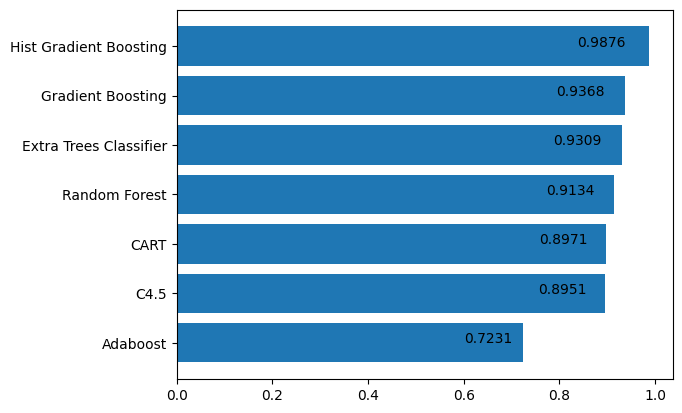

In [28]:
plt.rcdefaults()
fig, ax = plt.subplots()

df = pd.DataFrame(results)

df_sorted = df.sort_values('accuracy_score')

ax.barh('classifier', 'accuracy_score', data=df_sorted)
for i in range(len(results)):
    ax.text(results[i]['accuracy_score'] * 0.9, results[i]['classifier'], round(results[i]['accuracy_score'], 4), ha='center', color='black')
